# Exploratory code

The software in this file represents some of our explorations and experiments that were used to make our final analysis.

## Parsing the schema file

In [43]:
from schema import Schema
from tabulate import tabulate
from importlib import reload

In [44]:
schema = Schema("../data/schema.csv")
print(schema)


#########################################################################
job_events (job_events/part-?????-of-?????.csv.gz):
  field number  content           format       mandatory    formatter
--------------  ----------------  -----------  -----------  ----------------------------------------------------------------
             0  time              INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f62f10984c0>
             1  missing info      INTEGER      False        <function parse_schema_line.<locals>.<lambda> at 0x7f62f1099630>
             2  job ID            INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f62f11a30a0>
             3  event type        INTEGER      True         <function parse_schema_line.<locals>.<lambda> at 0x7f62f11a03a0>
             4  user              STRING_HASH  False        <function parse_schema_line.<locals>.<lambda> at 0x7f62f109b490>
             5  scheduling class  INTEGER      False 

## Starting Spark

In [45]:
from pyspark import SparkContext

# start spark with 1 worker thread
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at /tmp/ipykernel_8948/2436037330.py:4 

## Analysis on machine events

This file describes events that occurred to the machines in the cluster, as well as their specifications (initial events).

First, let us see the schema of this file's data:

In [ ]:
print(tabulate(schema.get_table_schema('machine_events')['fields'],headers='keys'))

### Machine Event RDD

In [ ]:
machine_events_get = schema.field_getters('machine_events')
machine_events = schema.load_rdd(sc,'machine_events')
machine_events.cache()

for elem in machine_events.take(5):
	print(elem)

[0, 5, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]
[0, 6, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]
[0, 7, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]
[0, 10, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]
[0, 13, 0, 'HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=', 0.5, 0.2493]


### Distribution of CPU usage (Q1)

For the following, we only account for the machine creation events. We note that this method could count a given machine more than once, should it happen to be added more than once (and removed in-between) or modified.

Distribution of machine capacity based on their CPU power:

In [ ]:
from operator import add

cpu = machine_events_get['CPUs']
event = machine_events_get['event type']
machine_id = machine_events_get['machine ID']
time = machine_events_get['time']

cpu_usage = machine_events \
    .filter(lambda row: event(row) == 0 and cpu(row) is not None) \
    .map(lambda row: (machine_id(row),row)) \
    .reduceByKey(lambda r1,r2: r1 if time(r1)>time(r2) else r2) \
    .map(lambda row: (cpu(row[1]), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for usage,nb in cpu_usage.collect():
    print(f"{nb} machines have CPU {usage}")


123 machines have CPU 0.25
11636 machines have CPU 0.5
796 machines have CPU 1.0


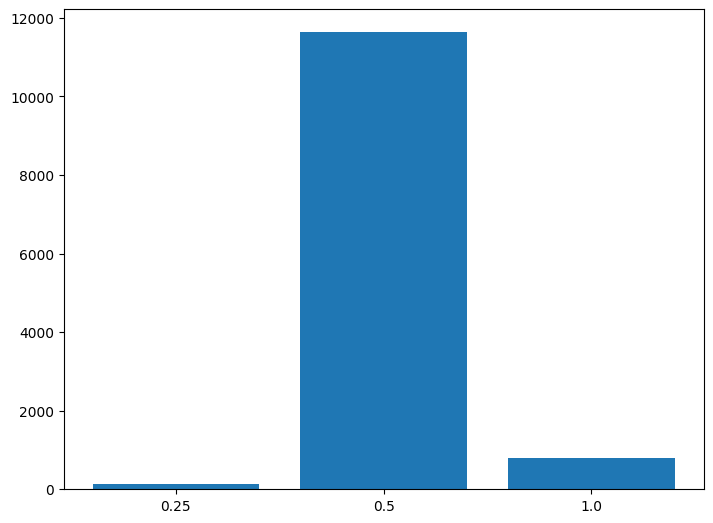

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
legend = cpu_usage.map(lambda x: str(x[0]) if x[0] is not None else 'None').collect()
count = cpu_usage.sortByKey().map(lambda x: x[1]).collect()
ax.bar(legend,count)
plt.show()

### Lost Computational Power

In [ ]:
machines_history = machine_events \
    .map(lambda row: (machine_id(row),row)) \
    .aggregateByKey(None,lambda acc, e: acc+[e] if acc is not None else [e],add) \
    .map(lambda machine: machine[1]) \

for e in machines_history.take(10):
    print(tabulate(e))

-  -  -  --------------------------------------------  ---  ------
0  6  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
-  -  -  --------------------------------------------  ---  ------
-------------  --  -  --------------------------------------------  ---  ------
            0  10  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
1306164355566  10  1  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
1307163081914  10  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
-------------  --  -  --------------------------------------------  ---  ------
-  --  -  --------------------------------------------  ---  ------
0  14  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
-  --  -  --------------------------------------------  ---  ------
-------------  --  -  --------------------------------------------  ---  ------
            0  26  0  HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=  0.5  0.2493
 611893094118  26  1  HofLGzk1Or/8I

In [ ]:
machines_history.filter(lambda m: sorted(m)).count() - machines_history.count()

0

The trace period starts at 600 seconds (aka $6 \times 10^{8}$ microseconds), to obtain the total trace time, we find the latest event time and subtracted $6 \times 10^{8}$ to it.

In [ ]:
from math import ceil

total_trace_time = time(machine_events.max(lambda row: time(row))) - 6*10**8

print(f'The total trace time is {total_trace_time} µs ≈ {ceil(total_trace_time/(10**6 * 3600))} hours ≈ {ceil(total_trace_time/(10**6 * 3600 * 24))} days')

The total trace time is 2505535493517 µs ≈ 696 hours ≈ 29 days


Once we have this number, computing the total computation power of a given machine is a matter of subtracting the starting time of the machine and multiplying by the CPU capacity. We assume here that the CPU capacity of a machine never changes, and we remove the machines that have some cpu values at None to prevent weird events.

In [ ]:
def lost_and_total_power(events):
    # Functions and Variables
    status = machine_events_get['event type']
    time = machine_events_get['time']
    start = time(events[0])
    cpu = machine_events_get['CPUs'](events[0])

    # Lost time
    lost_time = 0
    for i,m in enumerate(events):
        if i==0:
            continue
        if status(m)==0 and status(events[i-1])==1:
            lost_time += time(m) - time(events[i-1])
        
    # Total time
    total_time = total_trace_time if (start < 6*10**8) else (total_trace_time - start + 6*10**8)

    # Resulting power
    return (lost_time*cpu,total_time*cpu)

def has_none_cpu(events):
    cpu = machine_events_get['CPUs']
    for m in events:
        if cpu(m) is None:
            return True
    return False

print(f'There are {machines_history.filter(has_none_cpu).count()} machines with None values in their CPUs. They will not be evaluated.')

power_lost_and_total = machines_history \
    .filter(lambda m: not has_none_cpu(m)) \
    .map(lost_and_total_power) \
    .reduce(lambda p1,p2: (p1[0]+p2[0],p1[1]+p2[1]))

print(f'During the trace time, around {(power_lost_and_total[0]/power_lost_and_total[1])*100:.4f}% of the computational power was lost.\
\nThe exact percentage obtained is {(power_lost_and_total[0]/power_lost_and_total[1])*100}% !')


There are 32 machines with None values in their CPUs. They will not be evaluated.
During the trace time, around 0.4798% of the computational power was lost.
The exact percentage obtained is 0.4798129882918588% !


## Distribution of jobs and tasks per scheduling class

We will evaluate the distribution over **submitted** tasks and jobs. It also implies that we do not consider the distribution _over time_ but only within the _set_ of all submitted tasks and jobs.

We could also consider the evolution of the scheduling class through time, looking at the event types UPDATE_PENDING and UPDATE_RUNNING. This is a different perspective where time is a key component.

### Studying jobs

We start our analysis with jobs. They should be fewer, as there can be many tasks per job, but one job per task.

Before all, the schema for the tables we will use:

In [ ]:
print(tabulate(schema.get_table_schema('job_events')['fields'], headers='keys', maxcolwidths=40))

  field number  content           format       mandatory    formatter
--------------  ----------------  -----------  -----------  --------------------------------------
             0  time              INTEGER      True         <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7fa04ab72a70>
             1  missing info      INTEGER      False        <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7fa04ab72b90>
             2  job ID            INTEGER      True         <function
                                                            parse_schema_line.<locals>.<lambda> at
                                                            0x7fa04ab72c20>
             3  event type        INTEGER      True         <function
                          

First step, gather the events based on the task or job they refer to. We expect such lists of events to be small enough to be handled in regular python lists.

In [ ]:
job_events = schema.load_rdd(sc,'job_events')
job_events.persist()

job_events_get = schema.field_getters('job_events')

print(tabulate(job_events.take(10)))

-    -------  -  --------------------------------------------  -  --------------------------------------------  --------------------------------------------
0    3418309  0  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=  3  IHgtoxEBuUTHNbUeVs4hzptMY4n8rZKLbZg+Jh5fNG4=  wAmgn2H74cdoMuSFwJF3NaUEaudVBTZ0/HaNZBwIpEQ=
0    3418314  0  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=  3  L52XDyhi9x9ChmVBZ1qavOFmnzPeVsvQ2QyGmBZcV4s=  ShNjeaoUeqGV2i9WMKEX9HTeuc9K2Fdfovibt7Mp6qI=
0    3418319  0  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=  3  vq0IN3BWEbkDjYgYvkrVyH6OWoUoDwFFf3j/syEZzLA=  1A2GM17AzHRcKJcJet/oIF7FOORyFcAOcUSpR9Fqou8=
0    3418324  0  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=  3  X+Vce15Yu3BCKb7Ttc6hvINAzdfG3NtYEDNNsPdMGKo=  seczVo7MBfi/kH3+eH/40Hxs0l2YKFtXFnamcvMjSQI=
0    3418329  0  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=  3  EeK3DUWYi1P0vgBTp7wZdUos8UKj/+/FqudTLohMQ9M=  OEeQsaVr4kdGHFwQ2liQlDZ18529HEMmu6B6/3K1cBA=
0    3418334  0  70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgc

We are interested in the job submission event, which is when they are assigned their (initial) scheduling class.

In [ ]:
# event type 0 = SUBMIT
scheduling_events = job_events \
    .filter(lambda job_event: job_events_get['event type'](job_event) == 0)

The documentation says that it is possible for a job to be submitted more than once, when it has evicted, failed or been killed but still is runnable (up to a maximal number of trials).

Do we have any such situation ?

In [68]:
jobs_with_several_scheduling_classes = scheduling_events \
    .map(lambda job_event: (job_events_get['job ID'](job_event), 
                            [job_events_get['scheduling class'](job_event)])) \
    .reduceByKey(lambda event1, event2: event1 + event2) \
    .filter(lambda x: len(x[1]) > 1) \
    .count()

print(f'{jobs_with_several_scheduling_classes} jobs have more than one scheduling class.')

0 jobs have more than one scheduling class.


No.

Let us then proceed with gathering the scheduling classes.

In [47]:
job_scheduling_classes = scheduling_events \
    .map(lambda event: (job_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in job_scheduling_classes:
    print(scheduling_class)

(2, 1419)
(0, 919)
(3, 937)
(1, 1625)


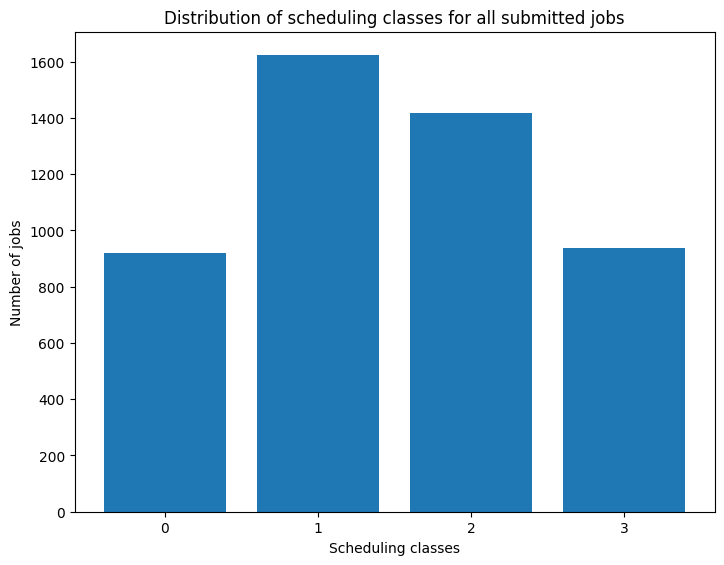

In [48]:
def bar_plot_question3(scheduling_classes, title):
    # TODO : make this into a proper function and put it in another file (plot.py ?)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    scheduling_class = list(map(lambda x: x[0], scheduling_classes))
    count = list(map(lambda x: x[1], scheduling_classes))
    ax.bar(scheduling_class,count)
    plt.xlabel("Scheduling classes")
    plt.ylabel("Number of jobs")
    plt.xticks(scheduling_class)
    plt.title(title)
    plt.show()

bar_plot_question3(job_scheduling_classes, "Distribution of scheduling classes for all submitted jobs")

### Repeating the analysis for tasks

Let us now do the same analysis for all tasks, irrespective of which job they belong to.

Starting with the schema of the tasks events table

In [49]:
task_events_get = schema.field_getters('task_events')

print(tabulate(
    schema.get_table_schema('task_events')['fields'], 
    headers='keys',
    maxcolwidths=[None, 20, None, None, 40]))

  field number  content             format       mandatory    formatter
--------------  ------------------  -----------  -----------  --------------------------------------
             0  time                INTEGER      True         <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f62f0b74940>
             1  missing info        INTEGER      False        <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f62f0b748b0>
             2  job ID              INTEGER      True         <function
                                                              parse_schema_line.<locals>.<lambda> at
                                                              0x7f62f0b74430>
             3  task index          INTEGER      True         <function
  

Then, we load the data and filter for submission events.

In [50]:
task_events = schema.load_rdd(sc,'task_events').persist()

task_submit_events = task_events.filter(
    lambda task_event: task_events_get['event type'](task_event) == 0)

# task_headers = map(lambda field: field['content'], task_events_schema['fields'])
# print(tabulate(task_submit_events.take(5), headers=task_headers))
for task_event in task_submit_events.take(5):
    print(task_event)

[0, 2, 3418309, 0, 4155527081, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]
[0, 2, 3418309, 1, 329150663, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]
[0, None, 3418314, 0, 3938719206, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, 0.125, 0.07446, 0.0004244, False]
[0, None, 3418314, 1, 351618647, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, 0.125, 0.07446, 0.0004244, False]
[0, 2, 3418319, 0, 431052910, 0, '70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=', 3, 9, None, None, None, None]


In [51]:
tasks_with_several_scheduling_classes = task_submit_events \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)), 
                        {task_events_get['scheduling class'](event)})) \
    .reduceByKey(lambda event1, event2: event1 | event2) \
    .filter(lambda x: len(x[1]) > 1)

print(f'{tasks_with_several_scheduling_classes.count()} tasks have more than one scheduling class.')

0 tasks have more than one scheduling class.


From this, we conclude that, as with jobs, no task has ever seen its scheduling class changed after being resubmitted (due to eviction, failure, kill).

In [53]:
task_scheduling_classes = task_submit_events \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .collect()

for scheduling_class in task_scheduling_classes:
    print(scheduling_class)

(2, 47599)
(0, 98066)
(3, 28192)
(1, 27634)


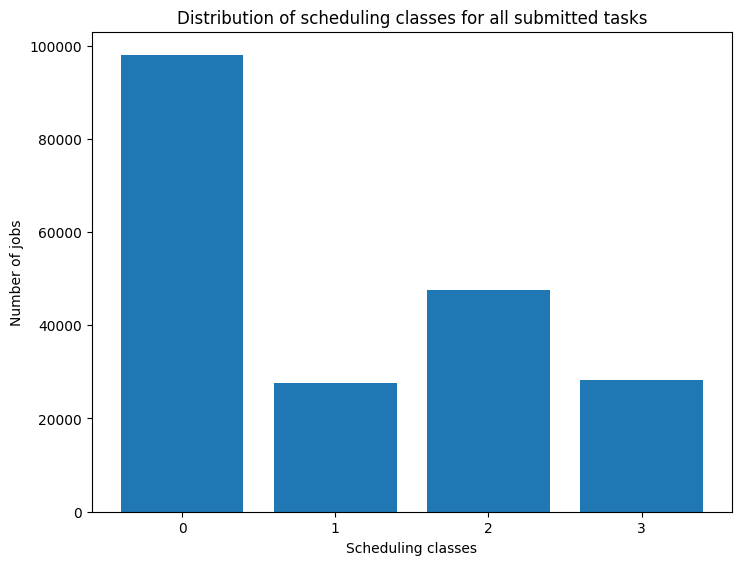

In [54]:
bar_plot_question3(task_scheduling_classes, "Distribution of scheduling classes for all submitted tasks")

## Relation between scheduling class and eviction of tasks

In [55]:
a_few = task_events \
    .filter(lambda event: task_events_get['event type'](event) == 2) \
    .map(lambda event: (task_events_get['scheduling class'](event), 1)) \
    .reduceByKey(add) \
    .sortBy(lambda x: x[0])

for one in a_few.collect():
    print(one)

(0, 2864)
(1, 792)
(2, 662)
(3, 20)


Tasks with lower scheduling class were evicted much more than those with higher scheduling class. Note that we chose to keep all eviction events, even when a single task is evicted several times.

It matches the idea that latency-sensitive tasks, represented with higher scheduling classes, need to be interrupted (namely evicted) as little as possible, so that they can be completed soon.

## Comparison of resource request and resource usage for tasks

This topic requires to do the analysis for three different resources: CPU cores, RAM and disk space. To start with, and become acquainted with the question at hand, we start with the CPU.

Tasks can specify resource requirements when submitted and upon UPDATE_PENDING and UPDATE_RUNNING events. Do they actually update their resource requests ?

In [79]:
multiple_cpu_request = task_events \
    .filter(lambda event: task_events_get['event type'](event) in [0, 7, 8]) \
    .map(lambda event: ((task_events_get['job ID'](event), task_events_get['task index'](event)),
        {task_events_get['CPU request'](event)})) \
    .reduceByKey(lambda cpu_request1, cpu_request2: cpu_request1 | cpu_request2) \
    .filter(lambda event: len(event[1]) > 1)

print(f"There has been {multiple_cpu_request.count()} tasks changing their CPU resource request during their lifetime. Here is a sample of those:")

for req in multiple_cpu_request.take(5):
    print(f"- task {req[0]} requested the following CPU allocations: {req[1]}")

There has been 93 tasks changing their CPU resource request during their lifetime. Here is a sample of those:
- task (1412625411, 85) requested the following CPU allocations: {0.1907, 0.0625}
- task (4392480606, 254) requested the following CPU allocations: {0.0813, 0.0625}
- task (4476805516, 226) requested the following CPU allocations: {0.01938, 0.1514}
- task (4476805516, 330) requested the following CPU allocations: {0.01938, 0.1514}
- task (4769197600, 4) requested the following CPU allocations: {0.06567, 0.1514}


As some tasks made more than one resource request in their lifetime, we need to handle those.

### Resource usage table

The resource usage information is stored in its own table. We will have to learn to use it, and also to match its data with the task events.

It is to be noted that resource measurement periods might overshoot after a task is killed. We might want to remove these parts of the measurements, if they prove problematic.

## Appendix

Alternate approach with SparkSQL, allowing the use of DataFrames:
from pyspark.sql import SparkSession

In [56]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local(*]") \
    .appName("Cluster analysis") \
    .getOrCreate()

### With DataFrames

It would be nice to have the tabular methods provided by DataFrames. Fortunately, Spark offers a DataFrame API, through their Spark SQL. To [load a CSV as a DataFrame](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.csv.html#pyspark.sql.DataFrameReader.csv),

In [57]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType
field_to_spark_type = {
    'time': LongType,
    'machine ID': LongType,
    'event type': IntegerType,
    'platform ID': StringType,
    'CPUs': FloatType,
    'Memory': FloatType
}
machine_events_schema = StructType([
    StructField(field['content'].replace(' ', '_'), field_to_spark_type[field['content']](), field['mandatory']) for field in schemas['machine_events']['fields']
])

machine_events = spark.read \
    .format('csv') \
    .option("header","true") \
    .schema(machine_events_schema) \
    .load("../data/machine_events/part-00000-of-00001.csv")

NameError: name 'schemas' is not defined

Let us check that the schema is as we expect

In [ ]:
machine_events.printSchema()

And inspect the first few data

In [ ]:
for elem in machine_events.take(5):
	print(elem.asDict())

How much events do we have?

In [ ]:
machine_events.count(), machine_events.filter(machine_events.event_type == 1).count(),machine_events.filter(machine_events.event_type == 2).count()

In [ ]:
machine_events.filter(machine_events.event_type == 0).CPUs